In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from math import *
from sklearn.metrics import mean_squared_error
from datetime import date
import calendar
import random

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,8

import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
_file = '/home/gopi34/Desktop/Desktopnew/PathFinder/lstm_/GHIAL_daily_sample_train.csv'
#change to python timeseries object
#dateparse = lambda dates: pd.datetime.strptime(dates, "%Y%U-%W")
data = pd.read_csv(_file, index_col= ['Date'], parse_dates=['Date'])
data = data.drop(['Day_No', 'Month_No', 'Week_Day', 'Week_No', 'Week_No_Mon'], axis=1)
print (data.head())
# print('\n')
# print(data.dtypes, '\n', data.index)

            Net_Sales
Date                 
2013-01-01    2163283
2013-01-02    2282643
2013-01-03    2358726
2013-01-04    2641822
2013-01-05    2574647


In [3]:
len(data)

730

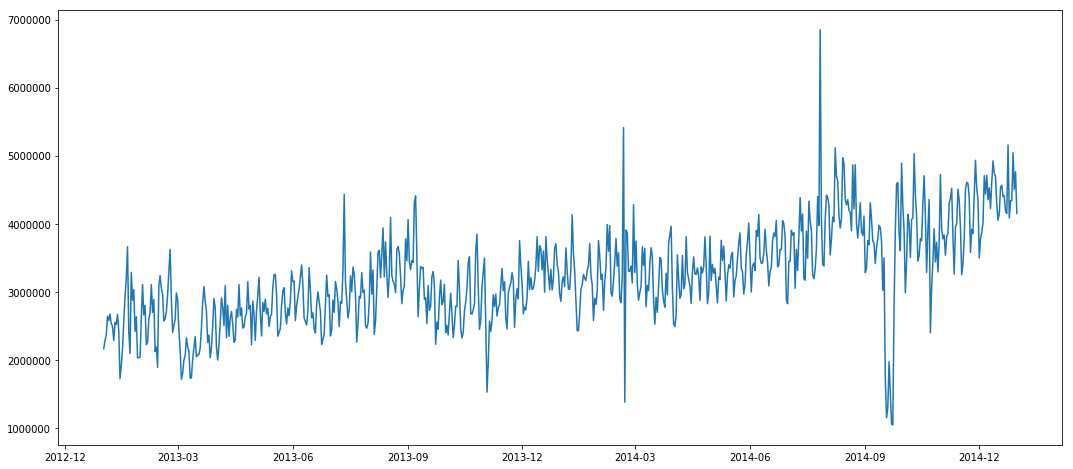

In [4]:
plt.plot(data)

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float("{0:.2f}".format(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
def rmse(y_true, y_pred):
    return float("{0:.2f}".format(sqrt(mean_squared_error(y_true, y_pred))))
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=60)
    rolstd = pd.rolling_std(timeseries, window=60)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def simple_moving_average(data, window_size, n_predictions):
    sma_pred = []
    for i in range(n_predictions):
        next_point = sum([int(i) for i in data[-window_size:]])/window_size
        sma_pred.append(next_point)
        data.append(next_point)
    return sma_pred

def exponential_weighted_moving_average(data_train, alpha_in, data_test):
    ewma_pred = []
    ema = list(data_train.ewm(alpha=alpha_in).mean())
    for i in data_test:
        next_point = alpha_in*i + (1-alpha_in) * ema[-1]
        ewma_pred.append(next_point)
        ema.append(next_point)
    return ewma_pred

# Simple Moving Average

In [6]:
#SMA preprocessing
train_data = data[:-7]
test_data = data[-7:]
windowsize = 7
train_data_SMA = list(pd.rolling_mean(train_data['Net_Sales'],window=windowsize))
y_hat = pd.DataFrame(test_data)
metrics = pd.DataFrame(columns=['SMA', 'EWMA', 'ARIMA', 'SARIMA', 'HOLT_WINTERS'], index=['RMSE','MAPE'])

#prediction using moving average
SMA = simple_moving_average(train_data_SMA, windowsize, len(test_data))
#store prediction to new dataframe
y_hat['SMA'] = [int(i) for i in SMA]

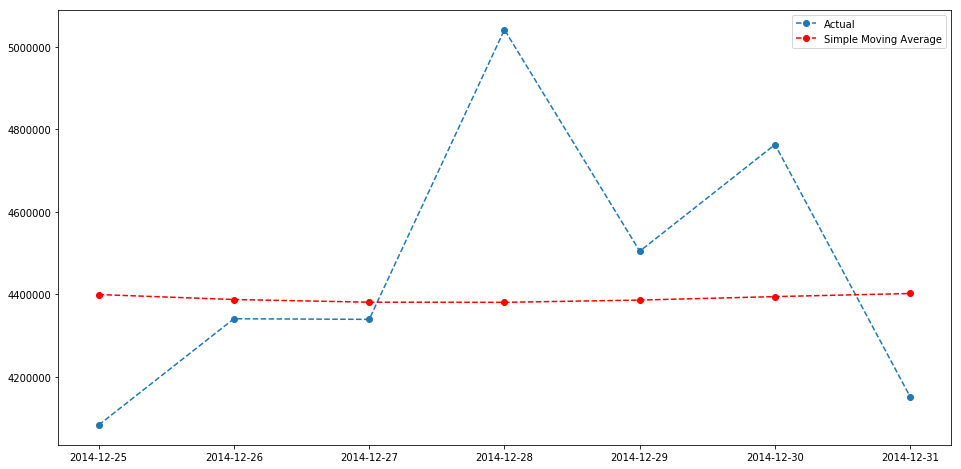

In [7]:
plt.figure(figsize=(16,8))
plt.plot(y_hat['Net_Sales'], linestyle='--', marker='o', label='Actual')
plt.plot(y_hat['SMA'], linestyle='--', marker='o', color='r', label='Simple Moving Average')
plt.legend(loc='best')
plt.show()

In [8]:
metrics.at['RMSE', 'SMA'] = rmse(y_hat['Net_Sales'], y_hat['SMA'])
metrics.at['MAPE', 'SMA'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['SMA'])

In [9]:
rmse(y_hat['Net_Sales'],y_hat['SMA'])

328155.44

In [10]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['SMA'])

5.61

# Exponentially Weighted Moving Average

In [11]:
#EWMA preprocessing
windowsize = 7
data_EWMA = pd.rolling_mean(data['Net_Sales'],window=windowsize).dropna()
train_data_ewma = data_EWMA[:-7]
test_data_ewma = data_EWMA[-7:]

#prediction using moving average
EWMA = exponential_weighted_moving_average(train_data_ewma, 0.9, test_data_ewma)
#store prediction to new dataframe
y_hat['EWMA'] = [int(i) for i in EWMA]

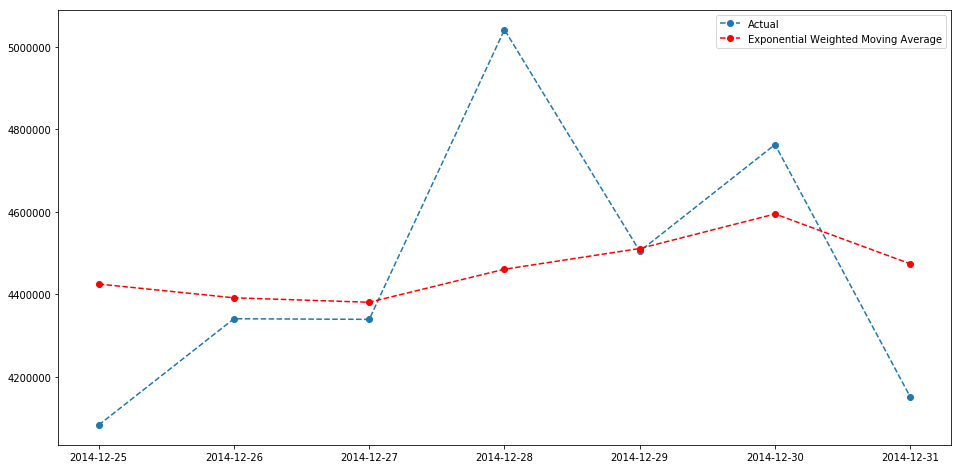

In [12]:
plt.figure(figsize=(16,8))
plt.plot(y_hat['Net_Sales'], linestyle='--', marker='o', label='Actual')
plt.plot(y_hat['EWMA'], linestyle='--', marker='o', color='r', label='Exponential Weighted Moving Average')
plt.legend(loc='best')
plt.show()

In [13]:
metrics.at['RMSE', 'EWMA'] = rmse(y_hat['Net_Sales'], y_hat['EWMA'])
metrics.at['MAPE', 'EWMA'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['EWMA'])

In [14]:
rmse(y_hat['Net_Sales'], y_hat['EWMA'])

290558.74

In [15]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['EWMA'])

4.78

## Exploratory Data Analysis

In [16]:
#import the data
eda_data = pd.read_csv(_file, index_col= ['Date'], parse_dates=['Date'])

Text(0.5,1,'Daywise Sales')

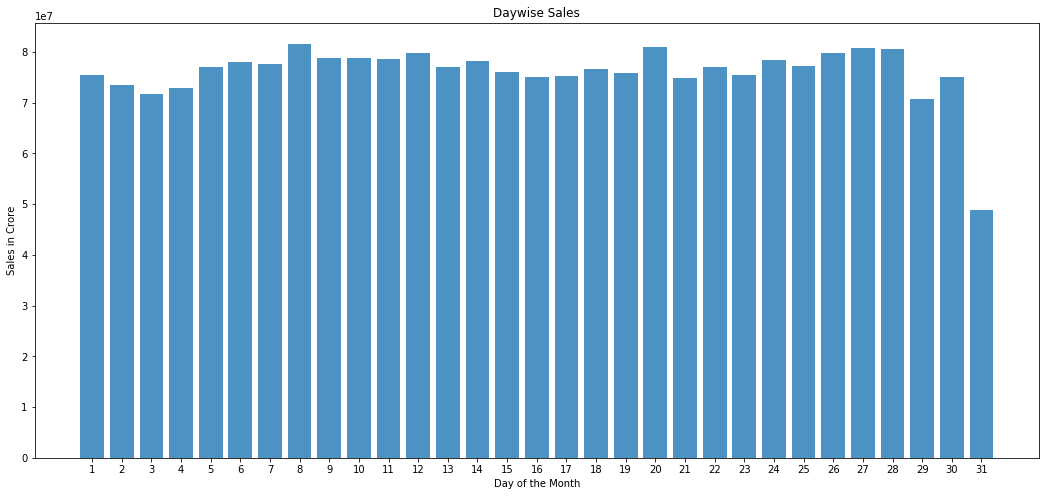

In [17]:
#groupby day of the month vs sales
daywise_sales = eda_data.groupby('Day_No')['Net_Sales'].sum()
y_pos = np.arange(1,len(daywise_sales)+1)
plt.bar(y_pos, daywise_sales, align='center', alpha=0.8)
plt.xticks(y_pos)
plt.ylabel('Sales in Crore')
plt.xlabel('Day of the Month')
plt.title('Daywise Sales')

Text(0.5,1,'Monthly Sales')

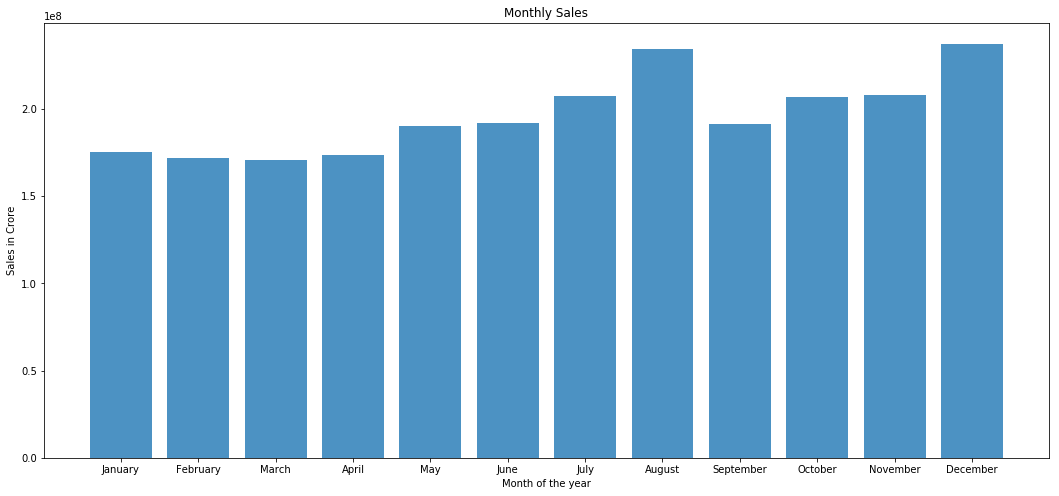

In [18]:
#groupby month vs sales
monthly_sales = eda_data.groupby('Month_No')['Net_Sales'].sum()
months = tuple([datetime.date(2018, i, 1).strftime('%B') for i in range(1,13)])
y_pos = np.arange(1,len(monthly_sales)+1)
plt.bar(y_pos, monthly_sales, align='center', alpha=0.8)
plt.xticks(y_pos, months)
plt.ylabel('Sales in Crore')
plt.xlabel('Month of the year')
plt.title('Monthly Sales')

Text(0.5,1,'WeekDay Sales')

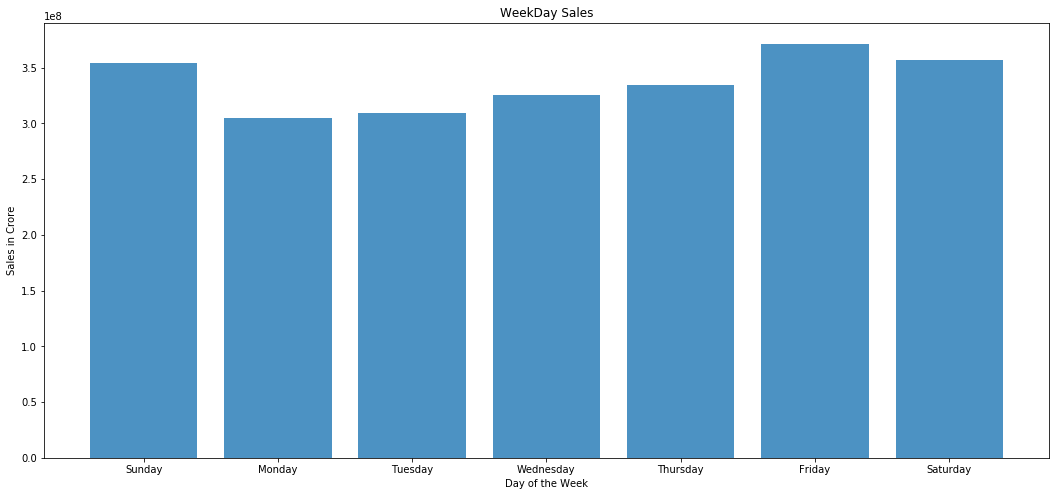

In [19]:
#groupby week of the month vs sales
weekday_sales = eda_data.groupby('Week_Day')['Net_Sales'].sum()
y_pos = np.arange(1,len(weekday_sales)+1)
#get day names from calendar module
day_name = list(calendar.day_name)
#make sunday as first day of the week
days = day_name[-1:] + day_name[:-1]
plt.bar(y_pos, weekday_sales, align='center', alpha=0.8)
plt.xticks(y_pos, days)
plt.ylabel('Sales in Crore')
plt.xlabel('Day of the Week')
plt.title('WeekDay Sales')

Text(0.5,1,'Week of the Month Sales')

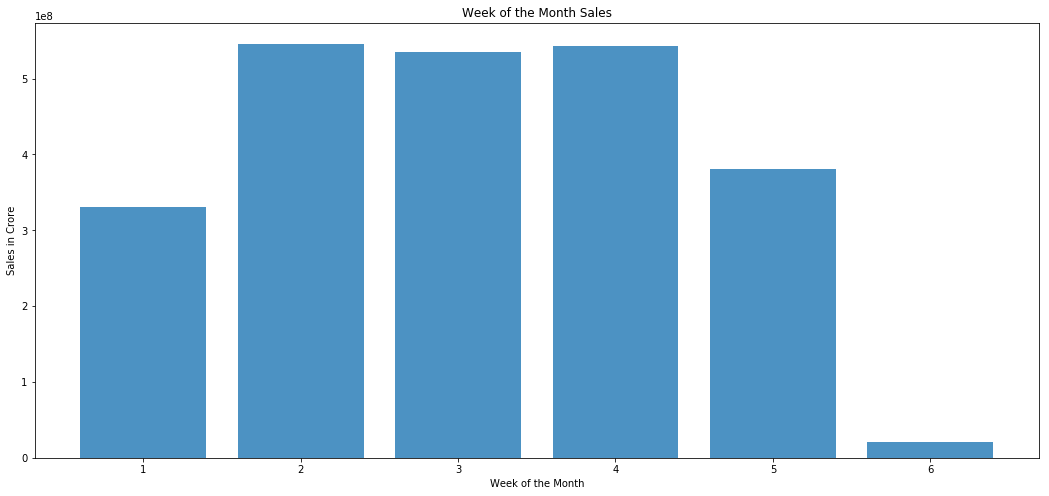

In [20]:
#groupby week number vs sales
WeekNo_sales = eda_data.groupby('Week_No_Mon')['Net_Sales'].sum()
y_pos = np.arange(1,len(WeekNo_sales)+1)
plt.bar(y_pos, WeekNo_sales, align='center', alpha=0.8)
plt.xticks(y_pos)
plt.ylabel('Sales in Crore')
plt.xlabel('Week of the Month')
plt.title('Week of the Month Sales')

# AR, MA and ARIMA Models

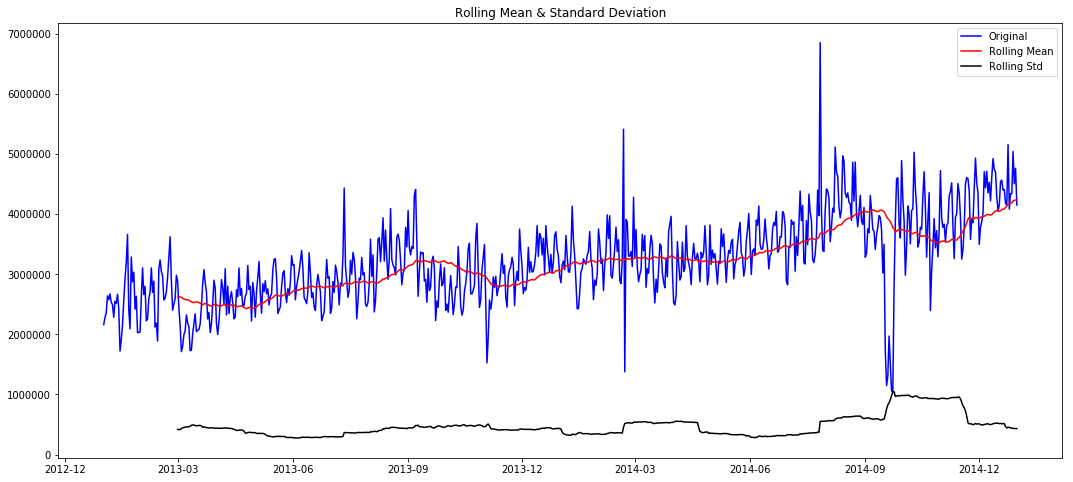

Results of Dickey-Fuller Test:
Test Statistic                  -1.299838
p-value                          0.629246
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
Critical Value (1%)             -3.439607
dtype: float64


In [21]:
test_stationarity(data)

In [22]:
data_log = np.log(data)

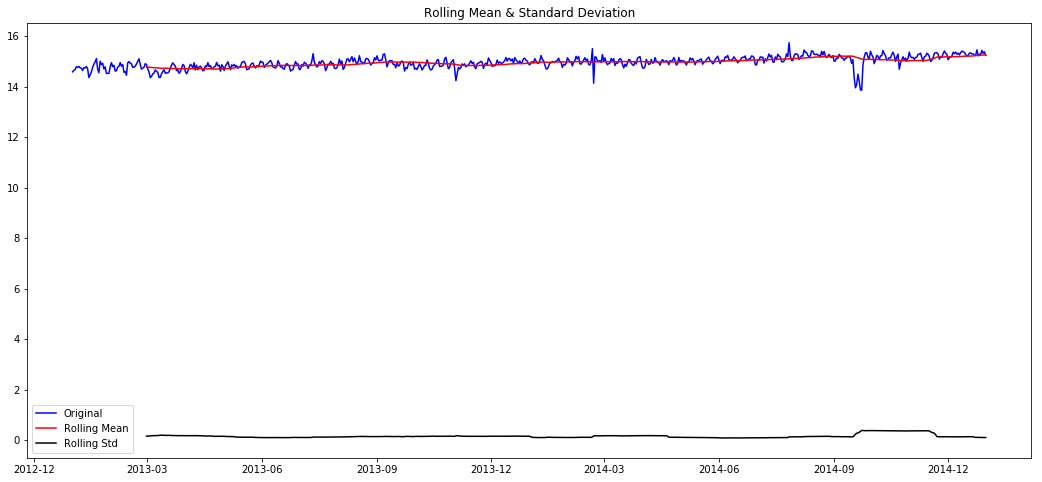

Results of Dickey-Fuller Test:
Test Statistic                  -1.823842
p-value                          0.368691
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
Critical Value (1%)             -3.439607
dtype: float64


In [23]:
test_stationarity(data_log)

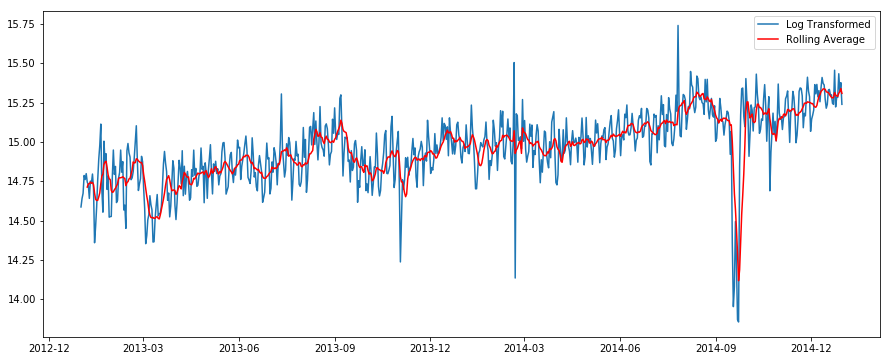

In [24]:
window = 7
Rolling_average = data_log.rolling(window = window, center= False).mean()
data_log_rolling = Rolling_average.dropna()
plt.figure(figsize=(15,6))
plt.plot(data_log, label = 'Log Transformed')
plt.plot(data_log_rolling, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

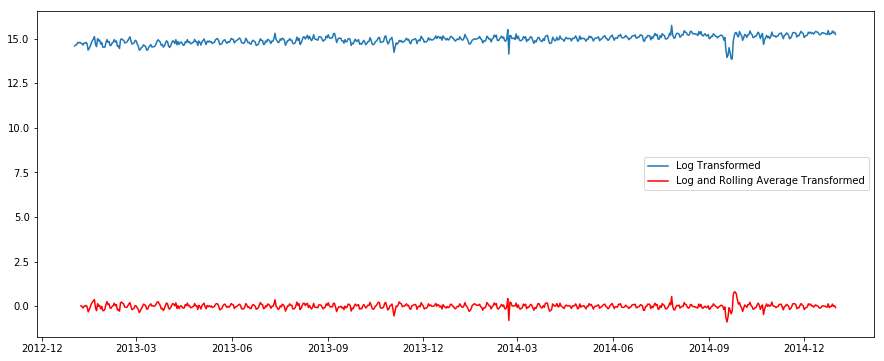

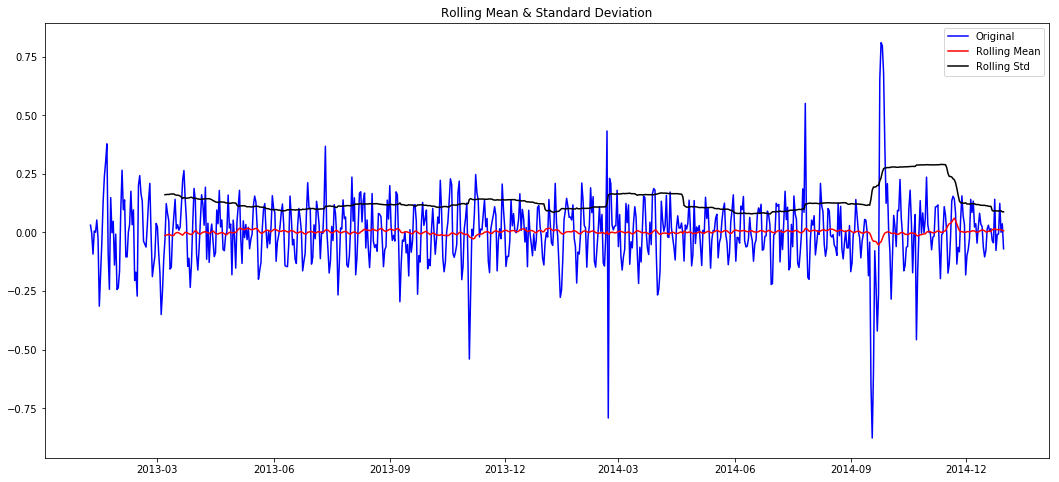

Results of Dickey-Fuller Test:
Test Statistic                -6.783718e+00
p-value                        2.462312e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
Critical Value (1%)           -3.439686e+00
dtype: float64


In [25]:
data_log_rolling = (data_log - data_log_rolling).dropna()
plt.figure(figsize=(15,6))
plt.plot(data_log, label = 'Log Transformed')
plt.plot(data_log_rolling, color = 'red', label = 'Log and Rolling Average Transformed')
plt.legend(loc = 'best')
plt.show()
test_stationarity(data_log_rolling)

In [26]:
# ACF and PACF plots
lag = 20
lag_pacf = pacf(data_log_rolling, nlags=lag, method='ols')
lag_acf = acf(data_log_rolling, nlags=lag)

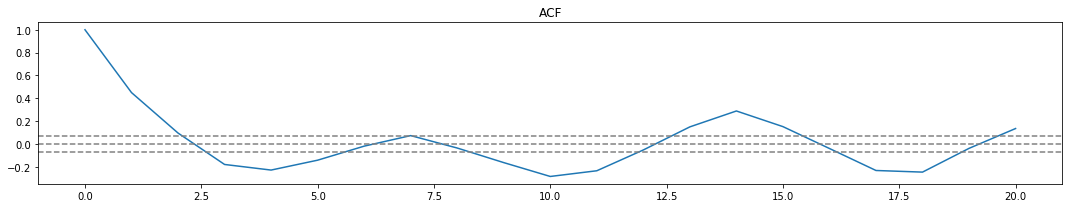

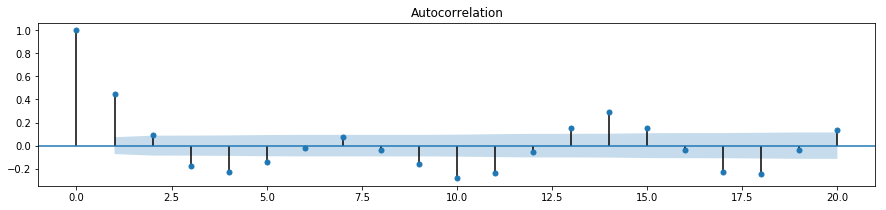

In [27]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_rolling)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_rolling)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(data_log_rolling, ax=plt.gca(),lags=lag)
plt.show()

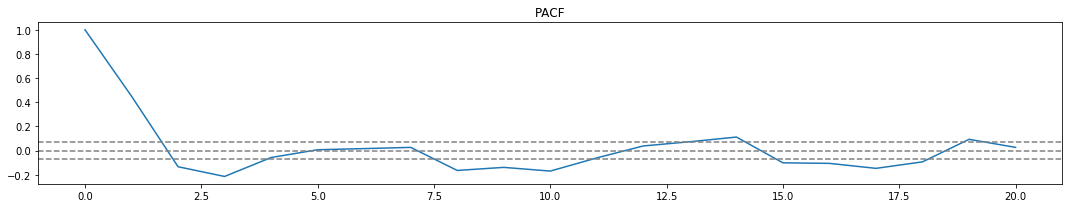

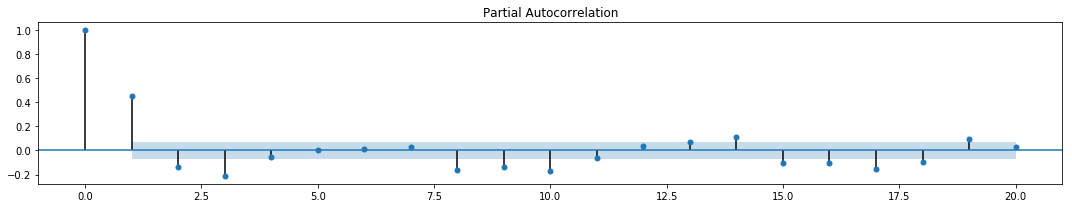

In [28]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_rolling)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_rolling)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(data_log_rolling, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

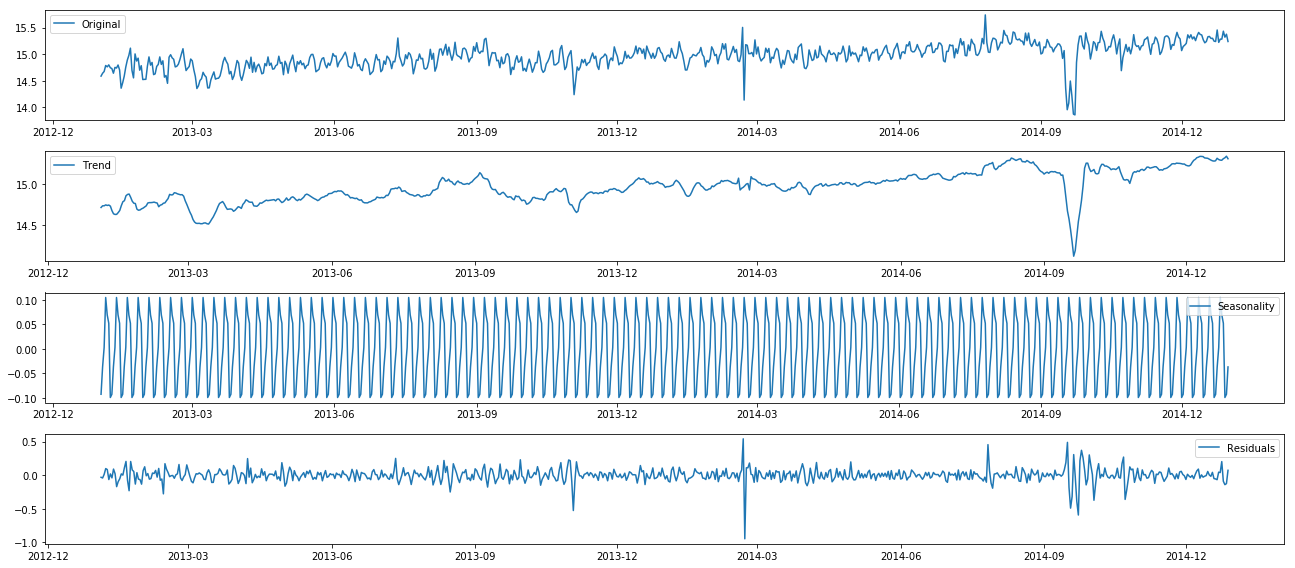

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

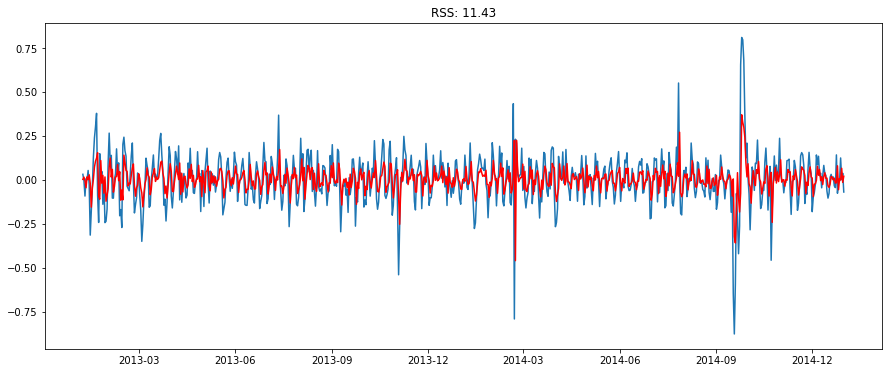

In [30]:
# AR
model = ARIMA(data_log_rolling, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,6))
plt.plot(data_log_rolling)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.2f'% sum((results_AR.fittedvalues-data_log_rolling.Net_Sales).dropna()**2))
plt.show()

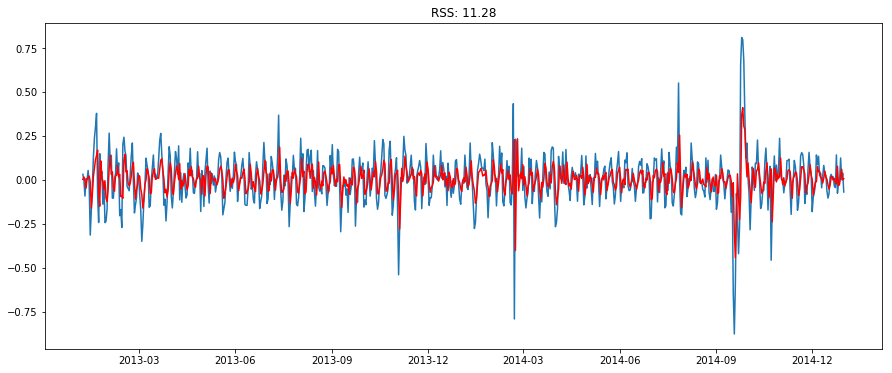

In [31]:
# MA
model = ARIMA(data_log_rolling, order=(0, 0, 2))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,6))
plt.plot(data_log_rolling)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.2f'% sum((results_AR.fittedvalues-data_log_rolling.Net_Sales).dropna()**2))
plt.show()

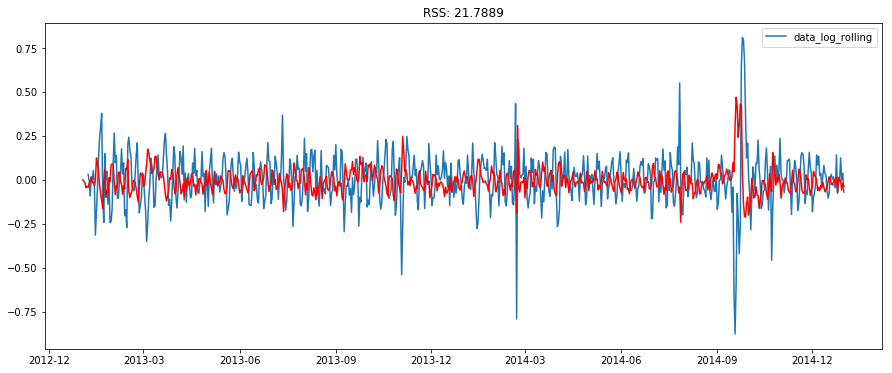

In [32]:
# ARIMA
model = ARIMA(data_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1, trend='nc')
plt.figure(figsize=(15,6))
plt.plot(data_log_rolling, label='data_log_rolling')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data_log_rolling.Net_Sales).dropna()**2))
plt.legend(loc='best')
plt.show()

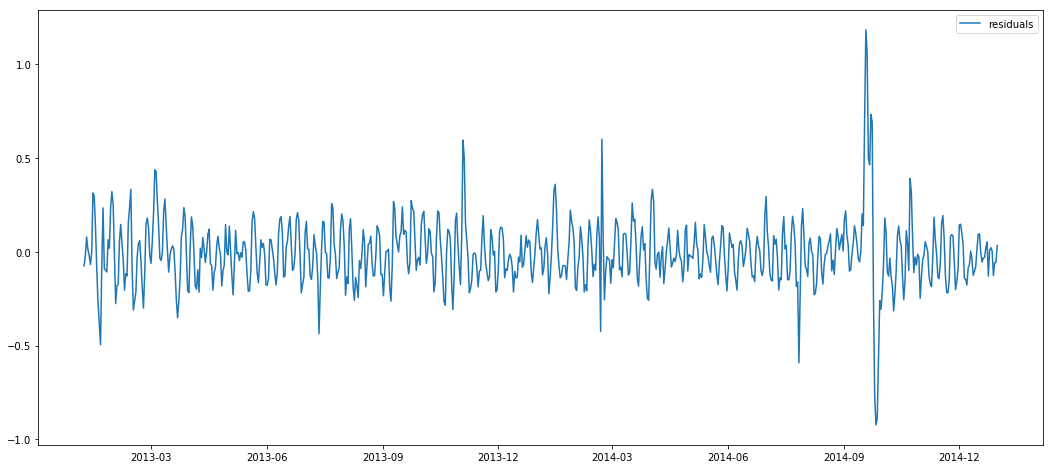

In [33]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = data_log_rolling.columns
x = x - data_log_rolling
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

In [34]:
pred = np.exp(results_ARIMA.forecast(7)[0])
y_hat['ARIMA'] = [int(i) for i in pred]

In [35]:
metrics.at['RMSE', 'ARIMA'] = rmse(y_hat['Net_Sales'], y_hat['ARIMA'])
metrics.at['MAPE', 'ARIMA'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['ARIMA'])

In [36]:
rmse(y_hat['Net_Sales'], y_hat['ARIMA'])

327519.31

In [37]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['ARIMA'])

5.16

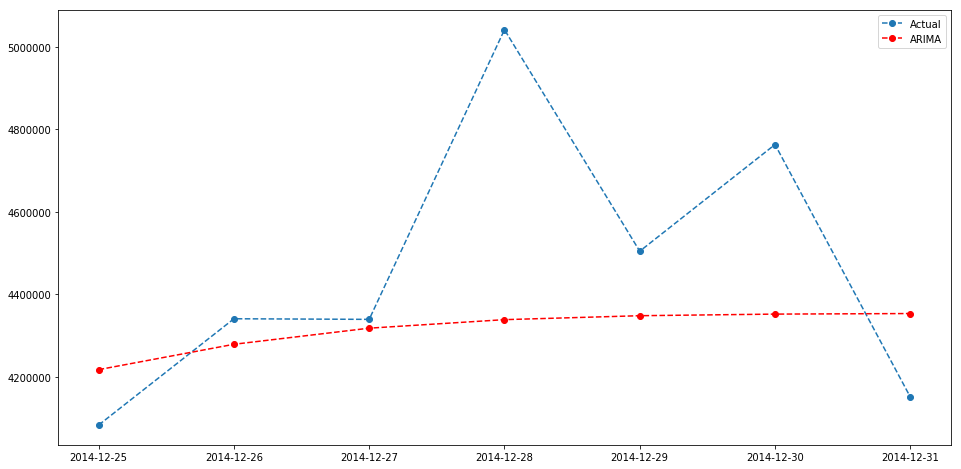

In [38]:
plt.figure(figsize=(16,8))
plt.plot(y_hat.Net_Sales, linestyle='--', marker='o', label='Actual')
plt.plot(y_hat.ARIMA, linestyle='--', marker='o', color='r', label='ARIMA')
plt.legend(loc='best')
plt.show()

# Seasonal ARIMA

In [39]:
from pyramid.arima import auto_arima

stepwise_fit = auto_arima(data_log, start_p=1, start_q=1, max_p=5, max_q=5, m=5,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 5); AIC=-738.742, BIC=-715.818, Fit time=1.955 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 5); AIC=-109.573, BIC=-100.404, Fit time=0.156 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 5); AIC=-272.846, BIC=-254.507, Fit time=0.588 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 5); AIC=-643.660, BIC=-625.320, Fit time=1.715 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 5); AIC=-738.266, BIC=-710.757, Fit time=2.615 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 5); AIC=-312.038, BIC=-293.699, Fit time=1.801 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 5); AIC=-691.004, BIC=-663.495, Fit time=2.835 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 5); AIC=-732.749, BIC=-700.655, Fit time=4.657 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                 374.371
Date:                           Thu, 01 Mar 2018   AIC                           -738.742
Time:                                   09:52:02   BIC                           -715.818
Sample:                                        0   HQIC                          -729.895
                                           - 730                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.176e-06   6.16e-06     -0.516      0.606   -1.53e-05     8.9e-06
ar.L1          0.5809      0.023     25.312      0.000       0.536       0.626
ma.L1         -0.9635      0.011    -91.321      0.000      -0.984      -0.943
ma.S.L5       -0.9883      0.020    -50.140      0.000      -1.027      -0.950
sigma2         0.0204      0.001     37.181      0.000       0.019       0.021
===================================================================================
Ljung-Box (Q):                      347.30   Jarque-Bera (JB):              3037.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
fit1 = sm.tsa.statespace.SARIMAX(train_data.Net_Sales, order=(0, 1, 3),seasonal_order=(2,1,2,30), enforce_stationarity=False, enforce_invertibility=False).fit()
y_hat['SARIMA'] = fit1.predict(start="2014-12-25", end="2014-12-31", dynamic=True)
y_hat['SARIMA'] = [int(i) for i in pd.Series(y_hat.SARIMA)]

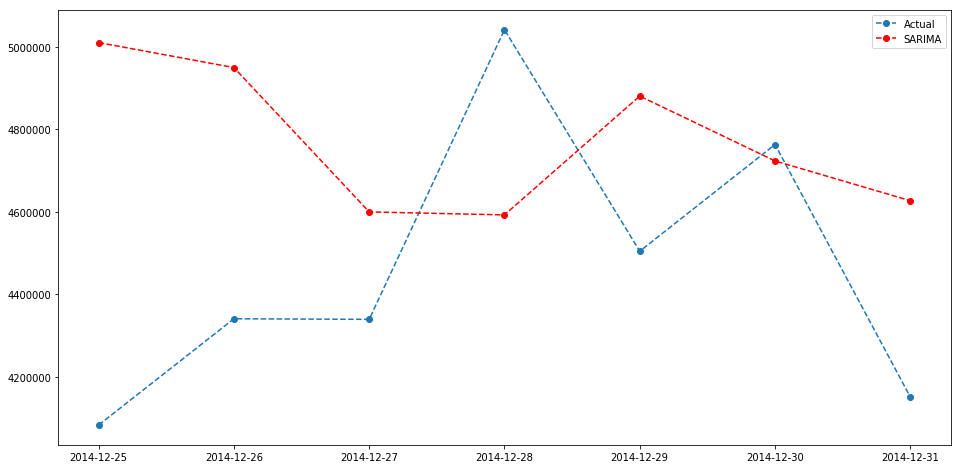

In [41]:
plt.figure(figsize=(16,8))
plt.plot(test_data['Net_Sales'], linestyle='--', marker='o', label='Actual')
plt.plot(y_hat['SARIMA'], linestyle='--', marker='o', color='r', label='SARIMA')
plt.legend(loc='best')
plt.show()

In [42]:
metrics.at['RMSE', 'SARIMA'] = rmse(y_hat['Net_Sales'], y_hat['SARIMA'])
metrics.at['MAPE', 'SARIMA'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['SARIMA'])

In [43]:
rmse(y_hat['Net_Sales'], y_hat['SARIMA'])

516806.43

In [44]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['SARIMA'])

10.33

# Holt Winters

In [45]:
fit1 = ExponentialSmoothing(np.asarray(data['Net_Sales']), seasonal_periods=365, trend='add', seasonal='mul',).fit()
y_hat['HOLT_WINTER'] = fit1.forecast(len(test_data))
y_hat['HOLT_WINTER'] = [int(i) for i in pd.Series(y_hat['HOLT_WINTER'])]

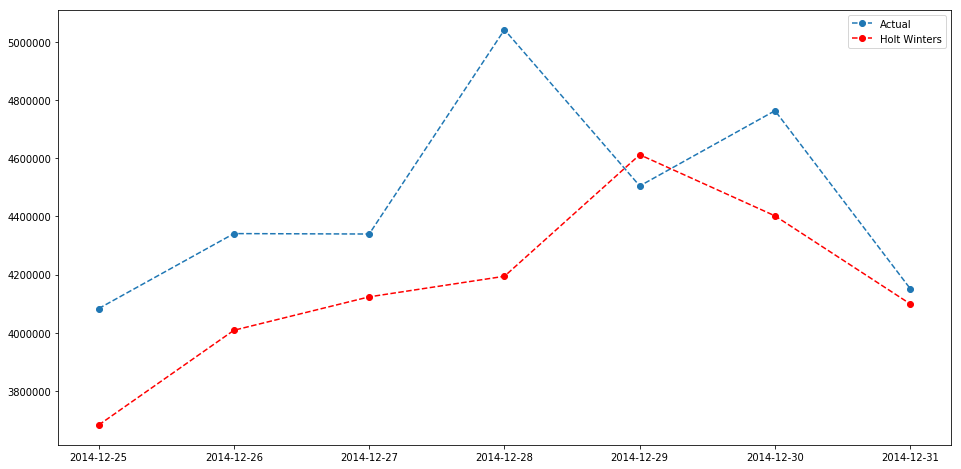

In [46]:
plt.figure(figsize=(16,8))
plt.plot(y_hat['Net_Sales'], linestyle='--', marker='o', label='Actual')
plt.plot(y_hat['HOLT_WINTER'], linestyle='--', marker='o', color='r', label='Holt Winters')
plt.legend(loc='best')
plt.show()

In [47]:
metrics.at['RMSE', 'HOLT_WINTERS'] = rmse(y_hat['Net_Sales'], y_hat['HOLT_WINTER'])
metrics.at['MAPE', 'HOLT_WINTERS'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['HOLT_WINTER'])

In [48]:
rmse(y_hat['Net_Sales'], y_hat['HOLT_WINTER'])

410663.28

In [49]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['HOLT_WINTER'])

7.21

# Regression Models

In [50]:
data_reg = data
data_reg['lag_1']  = data_reg.Net_Sales.shift(1)
data_reg['lag_2']  = data_reg.Net_Sales.shift(2)
data_reg = data_reg.dropna()
data_reg.head(5)

,Net_Sales,lag_1,lag_2
Date,,,
2013-01-03,2358726,2282643.0,2163283.0
2013-01-04,2641822,2358726.0,2282643.0
2013-01-05,2574647,2641822.0,2358726.0
2013-01-06,2673019,2574647.0,2641822.0
2013-01-07,2532202,2673019.0,2574647.0


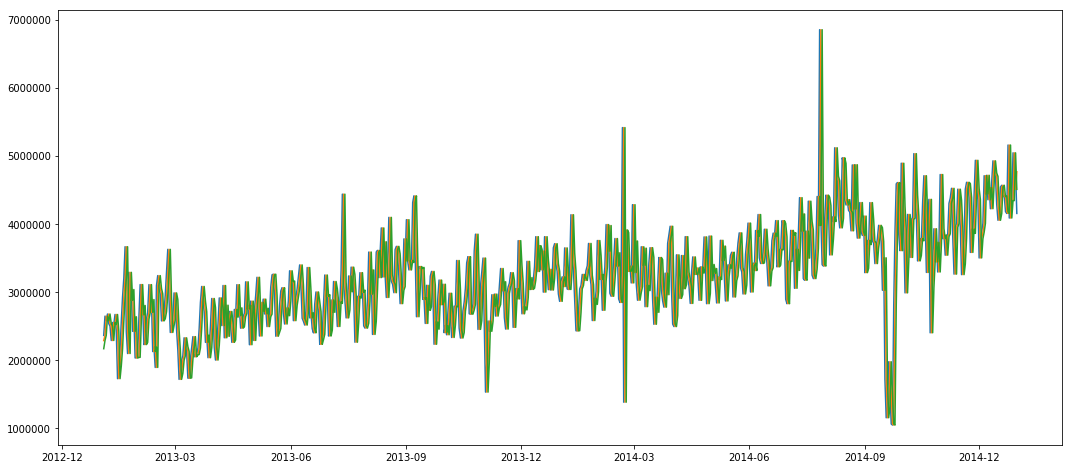

In [51]:
plt.plot(data_reg)

In [52]:
train_data_lr = data_reg[:-7]
test_data_lr = data_reg[-7:]

In [53]:
from sklearn.linear_model import LinearRegression as lr
lr_model = lr()
lr_model.fit(train_data_lr[['lag_1', 'lag_2']], train_data_lr['Net_Sales'])
b_0   = lr_model.intercept_
coeff = lr_model.coef_

In [54]:
# Let's predict the values for existing weeks (Testing)
y_hat['SLR'] = [int(i) for i in pd.Series(lr_model.predict(test_data_lr[['lag_1', 'lag_2']]))]

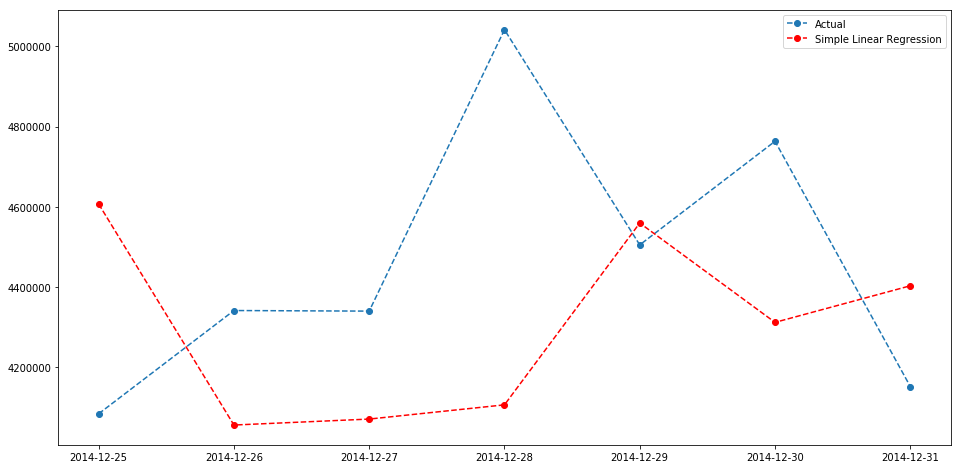

In [55]:
plt.figure(figsize=(16,8))
plt.plot(test_data_lr['Net_Sales'], linestyle='--', marker='o', label='Actual')
plt.plot(y_hat['SLR'], linestyle='--', marker='o', color='r', label='Simple Linear Regression')
plt.legend(loc='best')
plt.show()

In [56]:
metrics.at['RMSE', 'SLR'] = rmse(y_hat['Net_Sales'], y_hat['SLR'])
metrics.at['MAPE', 'SLR'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['SLR'])

In [57]:
rmse(y_hat['Net_Sales'], y_hat['SLR'])

474355.8

In [58]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['SLR'])

8.7

## Feature Engineered Regression

In [59]:
__file = '/home/gopi34/Desktop/Desktopnew/PathFinder/lstm_/lin_reg.csv'
#change to python timeseries object
#dateparse = lambda dates: pd.datetime.strptime(dates, "%Y%U-%W")
data_lr2 = pd.read_csv(__file, index_col= ['Date'], parse_dates=['Date'])
data_lr2 = data_lr2.drop(['WEEK_YEAR'], axis=1)

In [60]:
train_data_lr2 = data_lr2[:-7]
test_data_lr2 = data_lr2[-7:]
train_data_lr2Y = train_data_lr2[['NET_SALES']]
train_data_lr2X = train_data_lr2.drop(['NET_SALES'], axis=1)
test_data_lr2Y = test_data_lr2[['NET_SALES']]
test_data_lr2X = test_data_lr2.drop(['NET_SALES'], axis=1)

In [61]:
from sklearn.linear_model import LinearRegression as lr

lr_model_ = lr()
lr_model_.fit(train_data_lr2X, train_data_lr2Y)
score = lr_model_.score(train_data_lr2X, train_data_lr2Y)

b_0   = lr_model_.intercept_
coeff = lr_model_.coef_

y_hat['FE_LR'] = lr_model_.predict(test_data_lr2X)
y_hat['FE_LR'] = [int(i) for i in pd.Series(y_hat['FE_LR'])]

In [62]:
metrics.at['RMSE', 'FE_LR'] = rmse(y_hat['Net_Sales'], y_hat['FE_LR'])
metrics.at['MAPE', 'FE_LR'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['FE_LR'])

In [63]:
rmse(y_hat['Net_Sales'], y_hat['FE_LR'])

356057.99

In [64]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['FE_LR'])

6.26

## Ridge Regression

In [65]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge(alpha=0.003, normalize=True)

ridgeReg.fit(train_data_lr2X,train_data_lr2Y)

b_0   = ridgeReg.intercept_
coeff = ridgeReg.coef_

y_hat['RIDGE'] = ridgeReg.predict(test_data_lr2X)

y_hat['RIDGE'] = [int(i) for i in pd.Series(y_hat['RIDGE'])]

In [66]:
metrics.at['RMSE', 'RIDGE'] = rmse(y_hat['Net_Sales'], y_hat['RIDGE'])
metrics.at['MAPE', 'RIDGE'] = mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['RIDGE'])

In [67]:
rmse(y_hat['Net_Sales'], y_hat['RIDGE'])

356541.09

In [68]:
mean_absolute_percentage_error(y_hat['Net_Sales'], y_hat['RIDGE'])

6.27

In [69]:
y_hat

,Net_Sales,SMA,EWMA,ARIMA,SARIMA,HOLT_WINTER,SLR,FE_LR,RIDGE
Date,,,,,,,,,
2014-12-25,4083408,4399783,4425252,4217686,5010693,3683066,4606886,4359104,4357463
2014-12-26,4341058,4387707,4391888,4279178,4950011,4008808,4055331,4533232,4534910
2014-12-27,4339596,4381231,4381066,4318235,4600101,4123634,4070215,4352472,4355045
2014-12-28,5041891,4380905,4461169,4338889,4592889,4194385,4105683,4428730,4427769
2014-12-29,4504824,4386339,4511363,4348449,4880941,4612102,4559424,4477014,4476895
2014-12-30,4763443,4394751,4595084,4352347,4723670,4401908,4311530,4478303,4476955
2014-12-31,4151463,4402310,4474239,4353704,4627309,4099267,4402793,4713861,4714425


In [86]:
metrics

,SMA,EWMA,ARIMA,SARIMA,HOLT_WINTERS,SLR,FE_LR,RIDGE
RMSE,328155,290559,327519,516806,410663,474355.8,356057.99,356541.09
MAPE,5.61,4.78,5.16,10.33,7.21,8.7,6.26,6.27
